# Phasing via Cost function

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `PhasingViaCostFunction`
Phases every basis state $|x\rangle$ by an amount proportional to a cost function $f(x)$

This Bloq implements a unitary $U_f(\gamma)$ which phases each computational state on which
the wave-function has support, by an amount proportional to a function of that computational
basis state. The general unitary can be defined as
$$
    U_f(\gamma) = \sum_{x=0}^{N-1} e^{i 2 \pi \gamma f(x)} |x\rangle \langle x|
$$

The strategy to implement $U_f(\gamma)$ is to use two oracles $O_\text{direct}$
and $O_\text{phase}$ s.t.
$$
U_f(\gamma) = O_\text{direct}^\dagger(\mathbb{I}\otimes O_\text{phase})O_\text{direct}
$$

$O^\text{direct}$ evaluates a $b_\text{direct}$-bit approximation of the cost function $f(x)$
and stores it in a new output cost register. Note that the cost register can represent
arbitrary fixed point values and be of type `QFxp(b_direct, n_frac, signed)`.
$$
O^\text{direct}|x\rangle|0\rangle^{\otimes b_\text{direct}}_\text{cost}=|x\rangle|f(x)\rangle
$$

$O^\text{phase}$ acts on the cost register computed by $O^\text{direct}$ and phases the
state $|f(x)\rangle$ by $e^{i 2\pi \gamma f(x)}$
$$
O^\text{phase}(\gamma)=\sum_{k=0}^{2^{b_\text{direct}}-1}e^{i 2\pi\gamma k}|k\rangle\langle k|
$$


Different strategies for implementing the two oracles would give different costs tradeoffs.
See `QvrZPow` and `QvrPhaseGradient` for two different implementations of
phase oracles described in the reference.

#### Parameters
 - `cost_eval_oracle`: Cost function evaluation oracle. Must compute the cost in a newly allocated RIGHT register.
 - `phase_oracle`: Oracle to phase the cost register. Must consume the cost register allocated by `cost_eval_oracle` as a THRU input. 

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Appendix C: Oracles for phasing by cost function


In [2]:
from qualtran.bloqs.rotations import PhasingViaCostFunction

### Example Instances

In [3]:
from qualtran import QFxp, Register
from qualtran.bloqs.arithmetic import Square
from qualtran.bloqs.rotations.quantum_variable_rotation import QvrZPow

n, gamma, eps = 5, 0.1234, 1e-8
cost_reg = Register('result', QFxp(2 * n, 2 * n, signed=False))
cost_eval_oracle = Square(n)
phase_oracle = QvrZPow(cost_reg, gamma, eps)
square_via_zpow_phasing = PhasingViaCostFunction(cost_eval_oracle, phase_oracle)

In [4]:
from qualtran import QFxp, Register
from qualtran.bloqs.arithmetic import Square
from qualtran.bloqs.rotations.quantum_variable_rotation import QvrPhaseGradient

n, gamma, eps = 5, 0.1234, 1e-8
cost_reg = Register('result', QFxp(2 * n, 2 * n, signed=False))
cost_eval_oracle = Square(n)
phase_oracle = QvrPhaseGradient(cost_reg, gamma, eps)
square_via_phase_gradient = PhasingViaCostFunction(cost_eval_oracle, phase_oracle)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([square_via_phase_gradient, square_via_zpow_phasing],
           ['`square_via_phase_gradient`', '`square_via_zpow_phasing`'])

### Call Graph

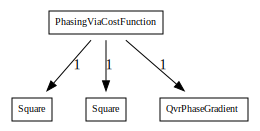

#### Counts totals:
 - `QvrPhaseGradient`: 1
 - `Square`: 1
 - `Square`: 1

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
square_via_phase_gradient_g, square_via_phase_gradient_sigma = square_via_phase_gradient.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(square_via_phase_gradient_g)
show_counts_sigma(square_via_phase_gradient_sigma)

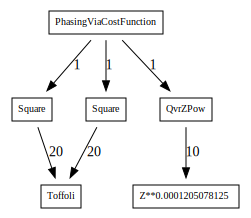

#### Counts totals:
 - `Toffoli`: 40
 - `Z**0.0001205078125`: 10

In [7]:
square_via_zpow_phasing_g, square_via_zpow_phasing_sigma = square_via_zpow_phasing.call_graph()
show_call_graph(square_via_zpow_phasing_g)
show_counts_sigma(square_via_zpow_phasing_sigma)